Package imports and paths

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

DATA_PATH = "data/mona.png"

Util functions

In [5]:
def show_img(img):
    plt.figure(figsize = (10,10))
    plt.imshow(img)

def export_channels(img):
    r,g,b = cv2.split(img)
    return r,g,b

def get_indices(img, win):
    step = 1/win
    x_w, y_w = (np.arange(win) * step), (np.arange(win) * step)

    x_w -= np.max(x_w)/2
    y_w -= np.max(y_w)/2

    x_n = np.repeat(x_w, img.shape[0]/win)
    x_n = x_n.reshape(win, int(img.shape[0]/win)).T
    y_n = np.repeat(y_w, img.shape[1]/win)
    y_n = y_n.reshape(win, int(img.shape[1]/win)).T

    x_n = [x_n[i]+i for i in range(x_n.shape[0])]
    y_n = [y_n[i]+i for i in range(y_n.shape[0])]
    x_n = np.array(x_n).flatten()
    y_n = np.array(y_n).flatten()

    X = np.repeat(x_n, len(x_n)).reshape(len(x_n),len(x_n))
    Y = np.repeat(y_n, len(y_n)).reshape(len(y_n),len(y_n)).T
    return X, Y

### HE

In [6]:
def hist_eq(img, n_bin=255, clip=False, limit=-1, interpolate=True):
    hist_range = (0, 256)
    hist, _ = np.histogram(img, bins=n_bin, range=hist_range)
    if clip:
        lim = np.floor(hist.max()*limit)
        overhead = 0.0
        for h in range(len(hist)):
            if lim < hist[h]:
                overhead += hist[h] - lim
                hist[h] = lim
        global_inc = overhead / n_bin
        hist += int(np.floor(global_inc))
    cum_sum = np.cumsum(hist, dtype=np.float64)
    cum_sum /= cum_sum[-1]
    cum_sum = np.uint8(cum_sum * 255)
    if not interpolate:
        return cum_sum
    indexes = np.int32((img/256) * n_bin)
    return cum_sum[indexes]

### AHE

In [7]:
def hist_adapt_eq(img, window=(32, 32), n_bin=255):
    tmp = np.zeros((img.shape[0] + window[0], img.shape[1] + window[1]), dtype=np.uint8)
    tmp[window[0] // 2:img.shape[0] + window[0] // 2, window[1] // 2:img.shape[1] + window[1] // 2] = img
    low_x = window[0]//2
    high_x = img.shape[0] + window[0]//2
    low_y = window[1]//2
    high_y = img.shape[1] + window[1]//2
    p = int(window[0]/2)
    equalized = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(low_x, high_x-1):
        for j in range(low_y, high_y - 1):
            abs_low_x = i - p
            abs_high_x = i + p
            abs_low_y = j - p
            abs_high_y = j + p
            chunk = tmp[abs_low_x:abs_high_x, abs_low_y:abs_high_y]
            tmp_he = hist_eq(chunk, n_bin)
            equalized[i-low_x,j-low_y] = tmp_he[low_x,low_y]
    return equalized

### AHE with blocks

In [8]:
def hist_adapt_eq_b(img, window=(32,32), he_bins=255):
    equalized = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(0, img.shape[0], window[0]):
        for j in range(0, img.shape[1], window[1]):
            if i >= img.shape[0]:
                rem_x = img.shape[0] - 1 - i
                chunk = img[i:i + rem_x, j:window[1] + j]
                tmp = hist_eq(chunk, he_bins)
                equalized[i:i + rem_x, j:window[1] + j,:] = tmp
                continue
            elif j >= img.shape[1]:
                rem_y = img.shape[1] - 1 - j
                chunk = img[i:window[0]+i, j:j+rem_y]
                tmp = hist_eq(chunk, he_bins)
                equalized[i:window[0] + i, j:j + rem_y] = tmp
                continue
            elif i >= img.shape[0] and j >= img.shape[1]:
                rem_x = img.shape[0] - 1 - i
                rem_y = img.shape[1] - 1 - j
                chunk = img[i:i + rem_x, j:j + rem_y]
                tmp = hist_eq(chunk, he_bins)
                equalized[i:i + rem_x, j:j + rem_y] = tmp
                continue
            chunk = img[i:window[0] + i, j:window[1] + j]
            tmp = hist_eq(chunk, he_bins)
            equalized[i:window[0] + i, j:window[1] + j] = tmp
    return equalized

### CLAHE

In [9]:
def clahe(img, limit, window=(32, 32), n_bin=255):
    tmp = np.empty((img.shape[0] + window[0], img.shape[1] + window[1]), dtype=np.uint8)
    tmp[window[0]//2:img.shape[0] + window[0]//2, window[1]//2:img.shape[1] + window[1]//2] = img
    low_x = window[0]//2
    high_x = img.shape[0] + window[0]//2
    low_y = window[1]//2
    high_y = img.shape[1] + window[1]//2
    p = int(window[0]/2)
    equalized = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(low_x, high_x - 1): #i and j are indices
        for j in range(low_y, high_y-1):
            abs_low_x = i - p
            abs_high_x = i + p
            abs_low_y = j - p
            abs_high_y = j + p
            chunk = tmp[abs_low_x:abs_high_x, abs_low_y:abs_high_y]
            tmp_he = hist_eq(chunk, n_bin, clip=True, limit=limit)
            equalized[i - low_x, j - low_y] = tmp_he[low_x, low_y]
    return equalized

### CLAHE with blocks

In [10]:
def clahe_b(img, limit, window=(32,32), he_bin=255, interpolate = True):
    equalized = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    x = 0
    y = 0
    x_blocks = img.shape[0]//window[0]
    y_blocks = img.shape[1]//window[1]
    blocks = np.empty((x_blocks, y_blocks, he_bin))
    for i in range(0, img.shape[0], window[0]):
        for j in range(0, img.shape[1], window[1]):
            chunk = img[i:window[0] + i, j:window[1] + j]
            tmp = hist_eq(chunk, he_bin, True, limit, interpolate)
            if not interpolate:
                blocks[y,x,:] = tmp
            else:
                equalized[i:window[0]+i, j:window[1]+j] = tmp
            x += 1
        x = 0
        y += 1
    if not interpolate:
        return blocks
    return equalized

### CLAHE with blocks and interpolation

In [11]:
def clahe_b_interpolate(img, limit, window=(32,32), he_bin=256):
    blocks = clahe_b(img, limit, window, he_bin, False)
    weights = get_indices(img, window[0])

    floor_h, floor_w = np.int32(np.floor(weights))
    ceil_h, ceil_w = np.int32(np.ceil(weights))

    equalized = np.empty(shape=img.shape)
    pad = int(window[0]/2)

    ind_h = weights[0] - floor_h
    ind_w = weights[1] - floor_w

    # based on https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Efficient_computation_by_interpolation, this chunk represents the red color
    equalized[0:pad, 0:pad] = blocks[0,                    0,                    img[0:pad, 0:pad]]
    equalized[0:pad, -pad:] = blocks[0,                    (blocks.shape[1]-1),  img[0:pad, -pad:]]
    equalized[-pad:, 0:pad] = blocks[(blocks.shape[0]-1),  0,                    img[-pad:, 0:pad]]
    equalized[-pad:, -pad:] = blocks[(blocks.shape[0]-1),  (blocks.shape[1]-1),  img[-pad:, -pad:]]

    # based on link above, this chunk represents the green color
    equalized[0:pad,pad:-pad] = blocks[ceil_h[0:pad,pad:-pad], floor_w[0:pad,pad:-pad], img[0:pad,pad:-pad]] * (1-ind_w[0:pad,pad:-pad]) + blocks[ceil_h[0:pad,pad:-pad],ceil_w[0:pad,pad:-pad],img[0:pad,pad:-pad]] * (ind_w[0:pad,pad:-pad])
    equalized[-pad:,pad:-pad] = blocks[floor_h[-pad:,pad:-pad],floor_w[-pad:,pad:-pad], img[-pad:,pad:-pad]] * (1-ind_w[-pad:,pad:-pad]) + blocks[floor_h[-pad:,pad:-pad],ceil_w[-pad:,pad:-pad],img[-pad:,pad:-pad]] * (ind_w[-pad:,pad:-pad])
    equalized[pad:-pad,0:pad] = blocks[floor_h[pad:-pad,0:pad],ceil_w[pad:-pad,0:pad], img[pad:-pad,0:pad]] * (1-ind_h[pad:-pad,0:pad]) + blocks[ceil_h[pad:-pad,0:pad],ceil_w[pad:-pad,0:pad],img[pad:-pad,0:pad]] * (ind_h[pad:-pad,0:pad])
    equalized[pad:-pad,-pad:] = blocks[floor_h[pad:-pad,-pad:],floor_w[pad:-pad,-pad:], img[pad:-pad,-pad:]] * (1-ind_h[pad:-pad,-pad:]) + blocks[ceil_h[pad:-pad,-pad:],floor_w[pad:-pad,-pad:],img[pad:-pad,-pad:]] * (ind_h[pad:-pad,-pad:])

    # based on link above, this chunk represents the blue color
    R1 = blocks[floor_h[pad:-pad,pad:-pad],floor_w[pad:-pad,pad:-pad],img[pad:-pad,pad:-pad]] * (1-ind_h[pad:-pad,pad:-pad]) + blocks[ceil_h[pad:-pad,pad:-pad],floor_w[pad:-pad,pad:-pad],img[pad:-pad,pad:-pad]] * (ind_h[pad:-pad,pad:-pad])
    R2 = blocks[floor_h[pad:-pad,pad:-pad],ceil_w[pad:-pad,pad:-pad],img[pad:-pad,pad:-pad]] * (1-ind_h[pad:-pad,pad:-pad]) + blocks[ceil_h[pad:-pad,pad:-pad],ceil_w[pad:-pad,pad:-pad],img[pad:-pad,pad:-pad]] * (ind_h[pad:-pad,pad:-pad])

    equalized[pad:-pad,pad:-pad] = R1 * (1-ind_w[pad:-pad,pad:-pad]) + R2 * ind_w[pad:-pad,pad:-pad]

    return equalized

Globals

In [12]:
bins = 255
depth = 8
limit = 0.4
win = 32

# DEMO

## Original

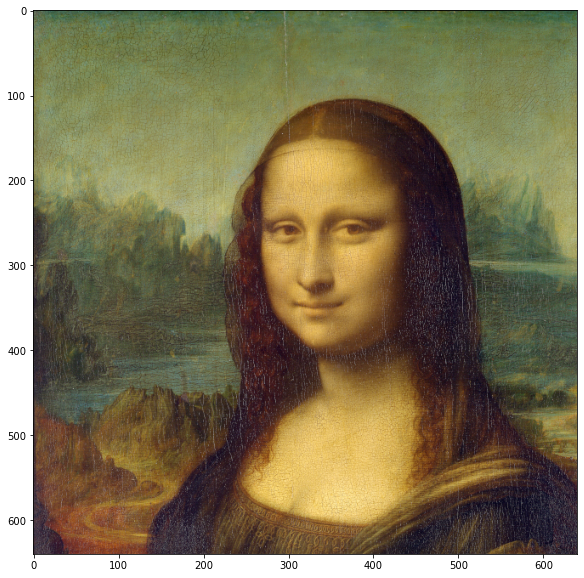

In [14]:
img_read = cv2.imread(DATA_PATH)
img_orig = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_read, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(img)
show_img(img_orig)

## HE

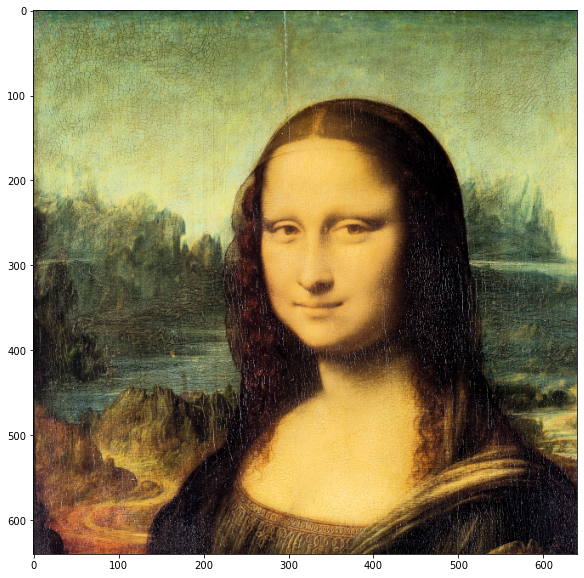

In [41]:
he_img = hist_eq(v, bins)
he_img = cv2.merge((h,s,he_img))
he_img = cv2.cvtColor(he_img, cv2.COLOR_HSV2RGB)
show_img(he_img)

## AHE

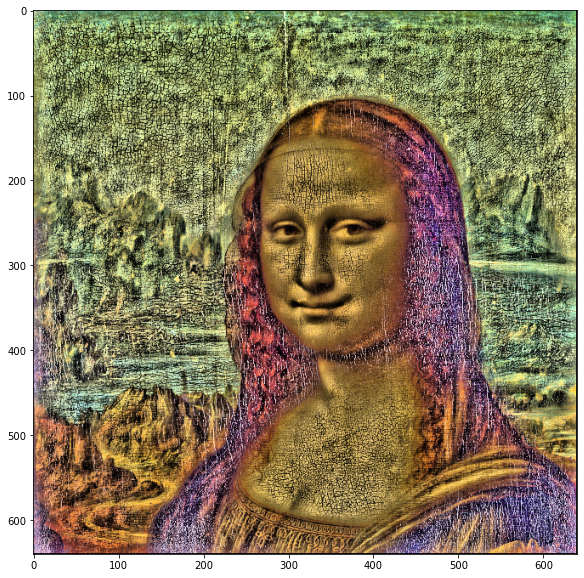

In [42]:
ahe_img = hist_adapt_eq(v, (win,win), bins)
ahe_img = cv2.merge((h,s,ahe_img))
ahe_img = cv2.cvtColor(ahe_img, cv2.COLOR_HSV2RGB)
show_img(ahe_img)

## CLAHE

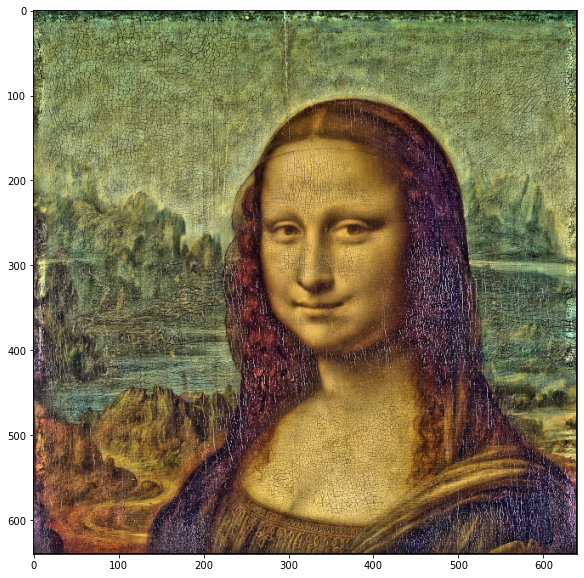

In [43]:
clahe_img = clahe(v, 0.2, (win,win), bins)
clahe_img = cv2.merge((h,s,clahe_img))
clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_HSV2RGB)
show_img(clahe_img)

## AHE with blocks

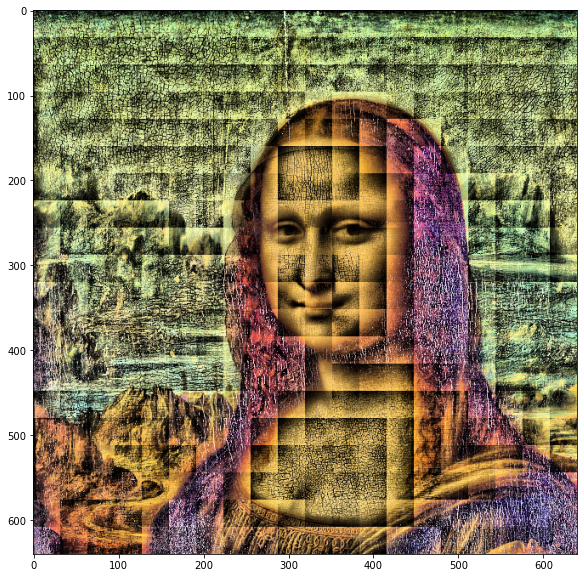

In [44]:
heb_img = hist_adapt_eq_b(v,(win,win), bins)
heb_img = cv2.merge((h,s,heb_img))
heb_img = cv2.cvtColor(heb_img, cv2.COLOR_HSV2RGB)
show_img(heb_img)

## CLAHE with blocks

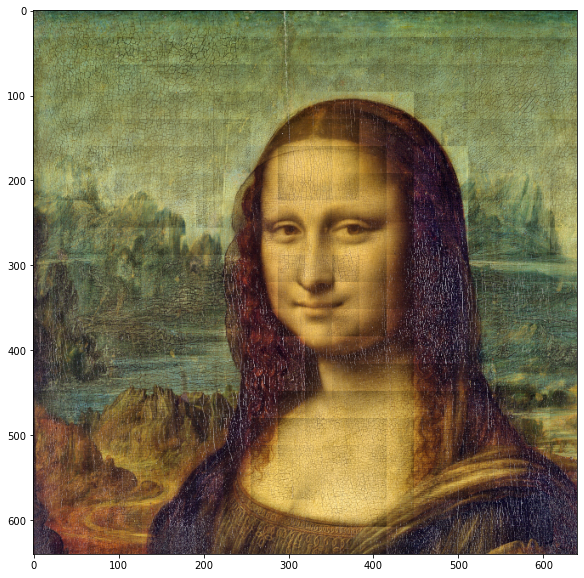

In [45]:
claheb_img = clahe_b(v, 0.1,(win,win),bins)
claheb_img = cv2.merge((h,s,claheb_img))
claheb_img = cv2.cvtColor(claheb_img, cv2.COLOR_HSV2RGB)
show_img(claheb_img)

## CLAHE with blocks and interpolation

In [19]:
clahebi_img = clahe_b_interpolate(v, limit, window=(32,32), he_bin=256)
clahebi_img = clahebi_img.astype(np.uint8)
final_img = cv2.merge((h,s,clahebi_img))
final_img = cv2.cvtColor(final_img, cv2.COLOR_HSV2RGB)
show_img(final_img)

img_read_2 = cv2.imread(DATA_PATH)
img_orig_2 = cv2.cvtColor(img_read_2, cv2.COLOR_BGR2RGB)
test_img = cv2.cvtColor(img_read_2, cv2.COLOR_BGR2HSV)
h2,s2,v2 = cv2.split(test_img)
clahebi_img_2 = clahe_b_interpolate(v2, limit, window=(4,4), he_bin=256)
clahebi_img_2 = clahebi_img_2.astype(np.uint8)
final_img_2 = cv2.merge((h2,s2,clahebi_img_2))
final_img_2 = cv2.cvtColor(final_img_2, cv2.COLOR_HSV2RGB)

KeyboardInterrupt: 